In [536]:
import numpy as np
import scipy.linalg as la
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize

In [537]:
def log_map(B, A):
    """finds for another point B a tangent vector V such that 
    the geodesic starting from A with tangent vector V 
    reaches B  after an arc length of ||V||_A = sqrt(<V, V>_A)
    
    A: starting point of the geodesic
    B: end point of the geodesic
    """
    a_sqrt = la.sqrtm(A)
    a_sqrtinv = la.inv(a_sqrt)
    return a_sqrt @ la.logm(a_sqrtinv @ B @ a_sqrtinv) @ a_sqrt

def exp_map(V, A):
    """sends a tangent vector onto the endpoint of a geodesic 
    starting from A with velocity Vector V
    
    A: start point on manifold
    V: velocity
    """
    a_sqrt = la.sqrtm(A)
    a_sqrtinv = la.inv(a_sqrt)
    return a_sqrt @ la.expm(a_sqrtinv @ V @ a_sqrtinv) @ a_sqrt

def spd_interp(A, B, t):
    assert(0 <= t <= 1 and "t must be in [0, 1]")
    va = log_map(A, A)
    vb = log_map(B, A)
    v = va + (vb - va) * t
    return exp_map(v, A)

def dist(A, B):
    b_sqrtinv = la.inv(la.sqrtm(B))
    return np.linalg.norm(la.logm(b_sqrtinv @ A @ b_sqrtinv), ord="fro")

In [616]:
l1 = 1.5
l2 = 1

def mid(alpha):
    return np.array([[l1 * np.cos(alpha)],
                     [l1 * np.sin(alpha)]])

def eef(alpha, beta):
    return np.array([[l1 * np.cos(alpha) + l2 * np.cos(alpha + beta)],
                     [l1 * np.sin(alpha) + l2 * np.sin(alpha + beta)]])
    

def jac(alpha, beta):
    return np.array([[-l1 * np.sin(alpha) - l2 * np.sin(alpha + beta), - l2 * np.sin(alpha + beta)],
                     [+l1 * np.cos(alpha) + l2 * np.cos(alpha + beta), + l2 * np.cos(alpha + beta)]])

In [617]:
jac_manip = jac(np.pi / 2, np.pi / 2)
jac_target = jac(np.pi / 3, np.pi / 3)

manip = jac_manip @ jac_manip.T
target = jac_target @ jac_target.T

In [618]:
dist(spd_interp(manip, target, 1), target)

1.8992298946791165e-15

In [619]:
spd_interp(manip, target, 1)

array([[ 5.4375    , -0.10825318],
       [-0.10825318,  0.3125    ]])

In [620]:
target

array([[ 5.4375    , -0.10825318],
       [-0.10825318,  0.3125    ]])

In [621]:
def plot_config(alpha, beta, ax, scale, **kwargs):
    jacobian = jac(alpha, beta)
    manip = jacobian @ jacobian.T 
    evecs, evals, _ = (np.real(v) for v in la.svd(manip))
    theta = np.linspace(0, 2 * np.pi, 200)
    ellipse = (1 / np.sqrt(evals)) * evecs @ np.array([np.sin(theta), np.cos(theta)]) / scale

    arm = np.array([[0, 0], *mid(alpha).T, *eef(alpha, beta).T]).T

    ax.plot(ellipse[0] + arm[0,-1], ellipse[1] + arm[1, -1], **kwargs)
    ax.plot(arm[0], arm[1], marker="o", **kwargs)

    ax.set_aspect('equal')

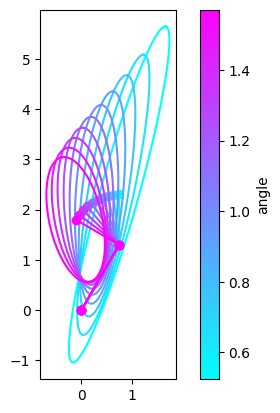

In [629]:
fig, ax = plt.subplots()
angles = np.linspace(np.pi / 6, np.pi / 2, 10)
cmap = get_cmap("cool")
norm = Normalize(vmin=angles.min(), vmax=angles.max())
mappable = ScalarMappable(norm, cmap)
for angle in angles:
    plot_config(np.pi / 3, angle, ax, 1, color=mappable.to_rgba(angle))
fig.colorbar(mappable, orientation="vertical", ax=ax, label="angle")
plt.show()

In [557]:
mappable.to_rgba(angles[0])

(0.001462, 0.000466, 0.013866, 1.0)

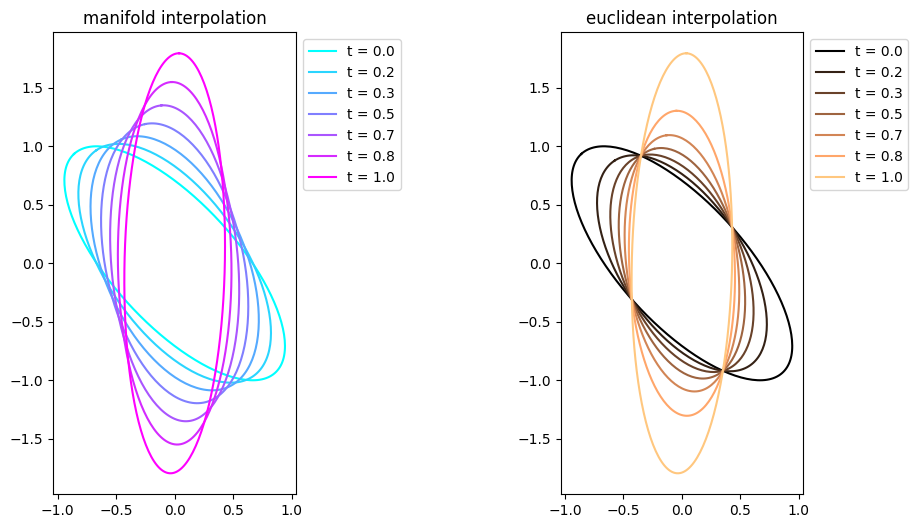

In [615]:
def get_ellipse(spd_mat):
    evecs, evals, _ = (np.real(v) for v in la.svd(spd_mat))
    theta = np.linspace(0, 2 * np.pi, 200)
    return (1 / np.sqrt(evals)) * evecs @ np.array([np.sin(theta), np.cos(theta)])
    
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

norm = Normalize(vmin=0, vmax=1)
mappable = ScalarMappable(norm, get_cmap("copper"))
N = 7

for offset, val in zip(np.linspace(0, 22, N), np.linspace(0, 1, N)):
    offset=0
    wrong_interp = get_ellipse(manip + (target - manip) * val)
    color = mappable.to_rgba(val)
    ax[1].plot(wrong_interp[0] + offset, wrong_interp[1], label=f"t = {val:.1f}", color=color)


mappable = ScalarMappable(norm, get_cmap("cool"))
for offset, val in zip(np.linspace(0, 22, N), np.linspace(0, 1, N)):
    interp = spd_interp(manip, target, val)
    color = mappable.to_rgba(val)
    
    ellipse = get_ellipse(interp)
    offset=0
    
    ax[0].plot(ellipse[0] + offset, ellipse[1], label=f"t = {val:.1f}", color=color)

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_title('manifold interpolation')
ax[1].set_title('euclidean interpolation')
ax[0].legend(bbox_to_anchor=(1, 1))
ax[1].legend(bbox_to_anchor=(1, 1))
plt.show()